# Short demonstration on how to work with your own datasets and combine these with model output

 - reading in data from an Excel spreadsheet
 - use the information to visualize on a map
 - plot timeseries of your data
 - scatter plot
 - extract model values at observation locations



### Importing packages and open file for reading
The pythonic way to write code is to import libraries and packages that you would like to use. Without these imports you will have access only to built-in functions, which often is not sufficent for doing what you want. 

In [1]:
from netCDF4 import Dataset #  This is handy for working with netCDF files
import numpy as np    # Package for scientific computing 
import matplotlib.pyplot as plt   # Package for plotting. A lot of the sytax is similar to matlab
from datetime import datetime,timedelta
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd # A powerful tool for working with datasets.Here it is used for loading an excel file with Økokyst data 


### Opening an Excel spreadsheet using pandas:

In [2]:
file = 'økokyst_msmdi_tilannkristin.xlsx'
xl = pd.ExcelFile(file) 
dataframe = xl.parse('Sheet1') # loading the content of the økokyst spreadsheet named Sheet1 into a data frame 


We can see what the dataframe contains by using the head and tail functions:

In [3]:
dataframe.head(10) # The 10 first entries

,station_id,name,year,month,long,lat,msmdi
0,111,Rauerkv,2009,sep,10.70413,59.25427,0.80
1,111,Rauerkv,2010,jun,10.70413,59.25427,0.74
2,111,Rauerkv,2011,mai,10.70413,59.25427,0.89
3,111,Rauerkv,2012,jun,10.70413,59.25427,0.90
4,111,Rauerkv,2013,jun,10.70413,59.25427,0.85
5,111,Rauerkv,2014,jun,10.70413,59.25427,0.54
6,111,Rauerkv,2015,jun,10.70413,59.25427,0.73
7,111,Rauerkv,2016,jun,10.70413,59.25427,0.75
8,111,Rauerkv,2017,sep,10.70413,59.25427,0.68
9,111,Rauerkv,2018,aug,10.70413,59.25427,0.65


In [4]:
dataframe.tail(10) # The 10 last entries

,station_id,name,year,month,long,lat,msmdi
269,HB9,Bertelsbkt,2016,jun,8.03593,58.14470,0.78
270,HR152,Østøya,2007,aug,10.48281,59.45012,0.76
271,HR152,Østøya,2010,aug,10.48281,59.45012,0.66
272,HR152,Østøya,2016,sep,10.48281,59.45012,0.66
273,HR152,Østøya,2017,sep,10.48281,59.45012,0.44
274,HT5,Akerøy,2007,okt,10.87016,59.04749,0.63
275,HT5,Akerøy,2010,sep,10.87016,59.04749,0.68
276,HT5,Akerøy,2016,sep,10.87016,59.04749,0.60
277,HT5,Akerøy,2017,sep,10.87016,59.04749,0.37
278,HT5,Akerøy,2018,aug,10.87016,59.04749,0.60


We can access the data by name of column and/or row:

The column names are the same as were given in the excel-file, while the row names in this case is simply the numbers listed to the left.



In [5]:
print('Print the station names:')
print(dataframe['name'])
print('')

print('Print the first row:\n')
print(dataframe.iloc[0])
print('')

print('Print the 275th row:\n')
print(dataframe.iloc[274]) # Remember that python indices start from 0
print('')

print('Print just the station name of the 275th row:\n')
print(dataframe['name'].iloc[274]) # Remember that python indices start from 0



Print the station names:
0      Rauerkv
1      Rauerkv
2      Rauerkv
3      Rauerkv
4      Rauerkv
        ...   
274     Akerøy
275     Akerøy
276     Akerøy
277     Akerøy
278     Akerøy
Name: name, Length: 279, dtype: object

Print the first row:

station_id        111
name          Rauerkv
year             2009
month             sep
long          10.7041
lat           59.2543
msmdi             0.8
Name: 0, dtype: object

Print the 275th row:

station_id        HT5
name           Akerøy
year             2007
month             okt
long          10.8702
lat           59.0475
msmdi            0.63
Name: 274, dtype: object

Print just the station name of the 275th row:

Akerøy


## Let's add some new columns to the dataframe. 
- a column with timestamps that makes sense to python.
- model temperature at the location 
- a measure of exposure -> we'll use 0.5*(u² + v²)



In [6]:
# Let's start with calculating datetime for every row in the dataframe 

# For simplicity we're assuming that all measurments were taken the 15th of the given month.

# Python doesn't know Norwegian so let's make a dictionary for translating month names given in the spreadsheet:
monthnames = {'mai':'may', 'okt':'oct'}

# we want to create a python datetime instance to plot the values with time as x-axis
# The number of rows and columns in the dataframe can be found by: 
rows, columns = dataframe.shape

observation_time = []
for n in range(rows):
    year = dataframe['year'].iloc[n]
    month =  dataframe['month'].iloc[n]

    if month in monthnames.keys():
        month = monthnames[month] # if the month we read from the data has a dictionary entry, replace it

    datestring = '15 {} {}'.format(month, year)

    observation_time.append(datetime.strptime(datestring, '%d %b %Y'))

# Now we have a list with datetime objects in the same order as the rows in the spreadsheet, 
print('An entry in the list look like this: ', observation_time[0])

print('The dataframe before adding a new column: \n')
dataframe.head(10)


An entry in the list look like this:  2009-09-15 00:00:00
The dataframe before adding a new column: 



,station_id,name,year,month,long,lat,msmdi
0,111,Rauerkv,2009,sep,10.70413,59.25427,0.80
1,111,Rauerkv,2010,jun,10.70413,59.25427,0.74
2,111,Rauerkv,2011,mai,10.70413,59.25427,0.89
3,111,Rauerkv,2012,jun,10.70413,59.25427,0.90
4,111,Rauerkv,2013,jun,10.70413,59.25427,0.85
5,111,Rauerkv,2014,jun,10.70413,59.25427,0.54
6,111,Rauerkv,2015,jun,10.70413,59.25427,0.73
7,111,Rauerkv,2016,jun,10.70413,59.25427,0.75
8,111,Rauerkv,2017,sep,10.70413,59.25427,0.68
9,111,Rauerkv,2018,aug,10.70413,59.25427,0.65


In [7]:
# Adding this list to the dataframe is quite simple:
dataframe['observation_time'] = observation_time

print('The dataframe after adding a new column: \n')
dataframe.head(10)

The dataframe after adding a new column: 



,station_id,name,year,month,long,lat,msmdi,observation_time
0,111,Rauerkv,2009,sep,10.70413,59.25427,0.80,2009-09-15
1,111,Rauerkv,2010,jun,10.70413,59.25427,0.74,2010-06-15
2,111,Rauerkv,2011,mai,10.70413,59.25427,0.89,2011-05-15
3,111,Rauerkv,2012,jun,10.70413,59.25427,0.90,2012-06-15
4,111,Rauerkv,2013,jun,10.70413,59.25427,0.85,2013-06-15
5,111,Rauerkv,2014,jun,10.70413,59.25427,0.54,2014-06-15
6,111,Rauerkv,2015,jun,10.70413,59.25427,0.73,2015-06-15
7,111,Rauerkv,2016,jun,10.70413,59.25427,0.75,2016-06-15
8,111,Rauerkv,2017,sep,10.70413,59.25427,0.68,2017-09-15
9,111,Rauerkv,2018,aug,10.70413,59.25427,0.65,2018-08-15


#### To add model temperature and measure of exposure, we need to read in some model data.  Since the Martini Control run is only a year long, we'll use the NorKyst-800 archive in this example

In [8]:
fid = Dataset('http://thredds.met.no/thredds/dodsC/sea/norkyst800mv0_24h_be')
# Access to the longitude, latitude coordinates
lon_NK = fid.variables['longitude'][:]
lat_NK = fid.variables['latitude'][:]

mask_NK = fid.variables['mask'][:]  # This is a mask which has values 0 in land-points, 1 in ocean points
h = fid.variables['h'][:]

# In the event that any of the stations are in a point the model believes is land, we want to use data 
# not from this point, but the closest ocean point. 
lat_NK[np.where(mask_NK == 0)] = 1000
lon_NK[np.where(mask_NK == 0)] = 1000


temp_NK = fid.variables['temperature']
u_NK = fid.variables['u'] # u-component of velocity
v_NK = fid.variables['v'] # v-component of velocity

time_NK = fid.variables['time'][:]

# Time on the file is in seconds since 1 January 1970. 
# convert this to python datetime objects 
reftime = datetime(1970,1,1)
time_NK = np.array( [ reftime + timedelta(seconds=t) for t in time_NK], dtype = datetime)



In [9]:
rlon = 0
rlat = 0
model_temperature = np.ones(rows)*np.nan
exposure = np.ones(rows) * np.nan

number_of_temperature_days = 45

exposure_days = 365

for n in range(rows):
    # There are many rows per station.
    # To avoid doing the same calculation over and over, store lat, lon in new variables,
    # and only calculate model grid indices the first time we encounter a new station in 
    # the dataset 
    
    if not ((rlon == dataframe['long'].iloc[n])  & (rlat == dataframe['lat'].iloc[n])): 
        rlon = dataframe['long'].iloc[n]
        rlat = dataframe['lat'].iloc[n]
        
    
        position_diff = np.abs( lat_NK[:] - rlat ) + np.abs( lon_NK[:] - rlon )

        # This line will find the indices of the minimum value in position_diff
        i, j = np.unravel_index( position_diff.argmin(), position_diff.shape )

        print('Grid indices of grid point closest to {}: {}, {}\n'.format(dataframe['name'].iloc[n], i, j))
        print('Grid point longitude: {}'.format(lon_NK[i,j]))
        print('Grid point latitude: {}'.format(lat_NK[i,j]))
        
    print( dataframe['observation_time'].iloc[n])
    
    timediff = np.array( [ (t - dataframe['observation_time'].iloc[n]).days  for t in time_NK] )

    # Find the indicies to calculate temperature from:
    timeind = np.argwhere( (timediff > -number_of_temperature_days)  & (timediff  < 1) )
    
    
    # The model dataset only has data starting the autumn of 2012. For observations taken
    # before the start of the model timeseries, timeind will be an empty array, 
    # that means len(timeind) will be zero in these cases. 
    
    # This if statement means we only do the indented command if len(timeind) is NOT 0
    if len(timeind):
    
        model_temperature [n] =  np.mean(temp_NK[np.int(timeind[0]): np.int(timeind[-1]+1), 0,  i, j])
    
    # Find the indicies to calculate exposure from:
    timeind = np.argwhere( (timediff > - exposure_days)  & (timediff  < 1) )
    
    if len(timeind):            
       
        exposure[n] =  np.mean( 0.5* ( u_NK[np.int(timeind[0]): np.int(timeind[-1]+1), 0,  i, j]**2 
                                        +   v_NK[np.int(timeind[0]): np.int(timeind[-1]+1), 0,  i, j]**2 )) 


    

dataframe['model_temperature'] = model_temperature

dataframe['exposure'] = exposure



Grid indices of grid point closest to Rauerkv: 143, 477

Grid point longitude: 10.701606750488281
Grid point latitude: 59.254669189453125
2009-09-15 00:00:00
2010-06-15 00:00:00
2011-05-15 00:00:00
2012-06-15 00:00:00
2013-06-15 00:00:00
2014-06-15 00:00:00
2015-06-15 00:00:00
2016-06-15 00:00:00
2017-09-15 00:00:00
2018-08-15 00:00:00
Grid indices of grid point closest to Bevøya S: 165, 505

Grid point longitude: 10.636244773864746
Grid point latitude: 59.5079345703125
2007-10-15 00:00:00
2010-09-15 00:00:00
2016-09-15 00:00:00
2017-09-15 00:00:00
Grid indices of grid point closest to Kråka: 112, 463

Grid point longitude: 10.973311424255371
Grid point latitude: 59.05466079711914
2007-10-15 00:00:00
2010-09-15 00:00:00
2016-09-15 00:00:00
2017-09-15 00:00:00
Grid indices of grid point closest to Gullholmen: 163, 494

Grid point longitude: 10.581435203552246
Grid point latitude: 59.432682037353516
2016-09-15 00:00:00
2017-09-15 00:00:00
2018-08-15 00:00:00
Grid indices of grid point cl

2012-06-15 00:00:00
2013-06-15 00:00:00
2014-06-15 00:00:00
2015-06-15 00:00:00
2016-06-15 00:00:00
Grid indices of grid point closest to Korsvik: 234, 246

Grid point longitude: 8.051036834716797
Grid point latitude: 58.13431167602539
2009-08-15 00:00:00
2010-06-15 00:00:00
2011-06-15 00:00:00
2012-06-15 00:00:00
2013-06-15 00:00:00
2014-06-15 00:00:00
2015-06-15 00:00:00
2016-06-15 00:00:00
Grid indices of grid point closest to Bertelsbkt: 236, 247

Grid point longitude: 8.033541679382324
Grid point latitude: 58.147308349609375
2009-08-15 00:00:00
2010-06-15 00:00:00
2011-06-15 00:00:00
2012-06-15 00:00:00
2013-06-15 00:00:00
2014-06-15 00:00:00
2015-06-15 00:00:00
2016-06-15 00:00:00
Grid indices of grid point closest to Østøya: 170, 492

Grid point longitude: 10.482006072998047
Grid point latitude: 59.445838928222656
2007-08-15 00:00:00
2010-08-15 00:00:00
2016-09-15 00:00:00
2017-09-15 00:00:00
Grid indices of grid point closest to Akerøy: 118, 458

Grid point longitude: 10.865847

In [10]:
dataframe.head(10)


,station_id,name,year,month,long,lat,msmdi,observation_time,model_temperature,exposure
0,111,Rauerkv,2009,sep,10.70413,59.25427,0.80,2009-09-15,NaN,NaN
1,111,Rauerkv,2010,jun,10.70413,59.25427,0.74,2010-06-15,NaN,NaN
2,111,Rauerkv,2011,mai,10.70413,59.25427,0.89,2011-05-15,NaN,NaN
3,111,Rauerkv,2012,jun,10.70413,59.25427,0.90,2012-06-15,NaN,NaN
4,111,Rauerkv,2013,jun,10.70413,59.25427,0.85,2013-06-15,9.185186,0.026994
5,111,Rauerkv,2014,jun,10.70413,59.25427,0.54,2014-06-15,10.922618,0.032794
6,111,Rauerkv,2015,jun,10.70413,59.25427,0.73,2015-06-15,10.523803,0.032375
7,111,Rauerkv,2016,jun,10.70413,59.25427,0.75,2016-06-15,11.020417,0.034784
8,111,Rauerkv,2017,sep,10.70413,59.25427,0.68,2017-09-15,16.248007,0.028629
9,111,Rauerkv,2018,aug,10.70413,59.25427,0.65,2018-08-15,19.427166,0.036821


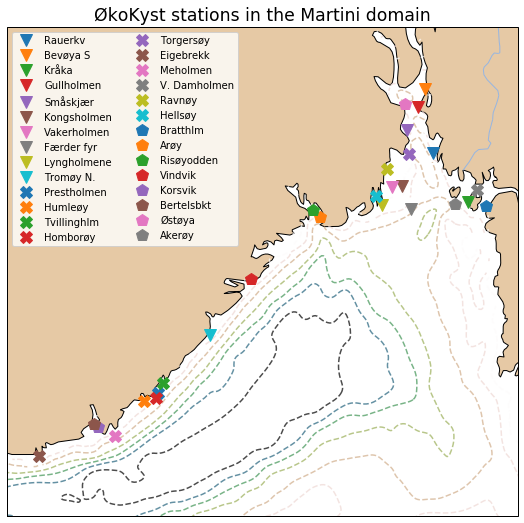

In [11]:
unique_stations = np.unique(dataframe['station_id']) # this creates an array of unique entries in the dataframe column 'station_id'


river_10m = cfeature.NaturalEarthFeature(
    category = 'physical', name = 'rivers_lake_centerlines',
    scale = '10m', facecolor = 'none', edgecolor = cfeature.COLORS['water'])

land_10m = cfeature.NaturalEarthFeature(
    category = 'physical', name = 'land',
    scale = '10m', edgecolor = 'none',facecolor = cfeature.COLORS['land'])

coastline_10m = cfeature.NaturalEarthFeature(
    category = 'physical', name = 'coastline',
    scale = '10m', edgecolor = 'k',facecolor = 'none')


mercator  = ccrs.Mercator() # Sets up the map projection 
fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw=dict(projection=mercator),  figsize=(12, 9))

# Let's zoom in on the domain based on the coordinates of the ØkoKyst stations
minlon = np.min(dataframe['long']) - 0.25 
maxlon = np.max(dataframe['long']) + 0.25 

minlat = np.min(dataframe['lat']) - 0.25 
maxlat = np.max(dataframe['lat']) + 0.25 

ax.set_extent([minlon,maxlon, minlat, maxlat], crs=ccrs.PlateCarree()) 


ax.add_feature( land_10m, facecolor = 'burlywood', alpha = 0.75 )
ax.add_feature(coastline_10m) # Adding coastline
ax.add_feature(river_10m) # Drawing rivers.


# Put a marker at the location of  ØkoKyst stations 
# By default, if color is not specified in the plot command, matplotlib will cycle over 10 standard colors. 
# Let's also cycle over some different marker symbols to better distinguish all the stations from one another
markers = ['v', 'X', 'p']  # For more options, see https://matplotlib.org/3.1.1/api/markers_api.html

markercount = -1
for n in range(len(unique_stations)):  # loop over unique station ids
    station = unique_stations[n]
    
    if np.mod(n, 10) == 0:  # Remainder  of division. Will be zero for 0, 10, 20, 30, and so on
        markercount += 1 # Everytime this if statement is true, the marker symbol used for plotting will change
        mark = markers[markercount]

        
    is_station = dataframe['station_id']==station  # Find where in the dataframe station id is equal to the current station value
    new_dataframe = dataframe[is_station] # Extract that part into a new datafram
    
    datalat = new_dataframe['lat'].iloc[0]
    datalon = new_dataframe['long'].iloc[0]
        
    ax.plot(datalon,  datalat, linestyle = 'none', transform = ccrs.PlateCarree(),  marker =mark, markersize=12, label = np.unique(new_dataframe['name'])[0])


# Adding the depth contours, using the x,y coordinates specified for the native Martini-projection:
# Note that the transform argument points to the native martini projection we used above.
h[np.where(mask_NK == 0)] = np.nan
ax.contour(lon_NK[:], lat_NK[:] , h, levels = [25, 50, 100, 200, 300, 400, 500], cmap =plt.cm.gist_earth_r, alpha = 0.7, linestyles = 'dashed', transform = ccrs.PlateCarree())


plt.legend(loc = 'upper left', ncol = 2);
plt.title('ØkoKyst stations in the Martini domain', fontsize = 'xx-large');

/home/annks/software/miniconda3/envs/martini/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


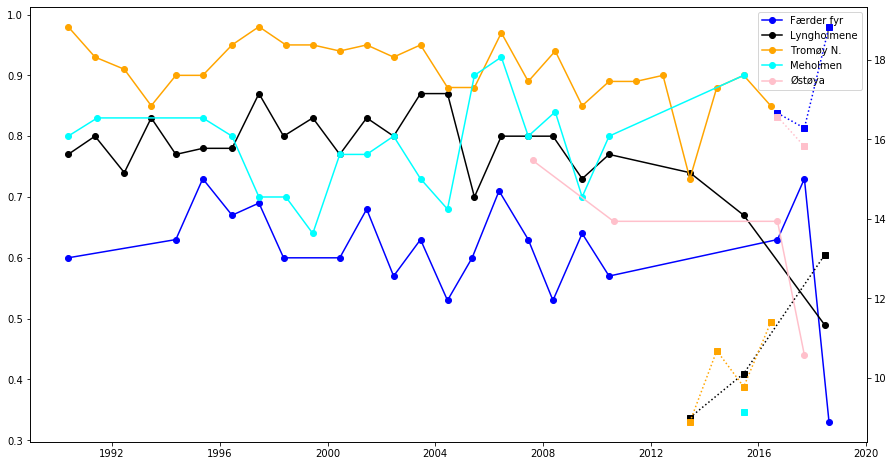

In [12]:
# Let's make a plot of the evolution of msmdi at some selected locations:


fig, ax1 = plt.subplots(figsize=(15,8))
ax2 = ax1.twinx()
colors = {'Færder fyr': 'blue', 'Lyngholmene': 'black', 'Tromøy N.':'orange', 'Meholmen':'cyan', 'Østøya':'pink'}
for name in ['Færder fyr', 'Lyngholmene', 'Tromøy N.', 'Meholmen', 'Østøya']:
    

    is_station =  dataframe['name']== name
    new_dataframe = dataframe[is_station]


    ax1.plot(new_dataframe['observation_time'], new_dataframe['msmdi'], marker='o', label = name, color=colors[name])
    
        
    ax2.plot(new_dataframe['observation_time'], new_dataframe['model_temperature'], linestyle='dotted', marker ='s',color = colors[name])
ax1.legend()





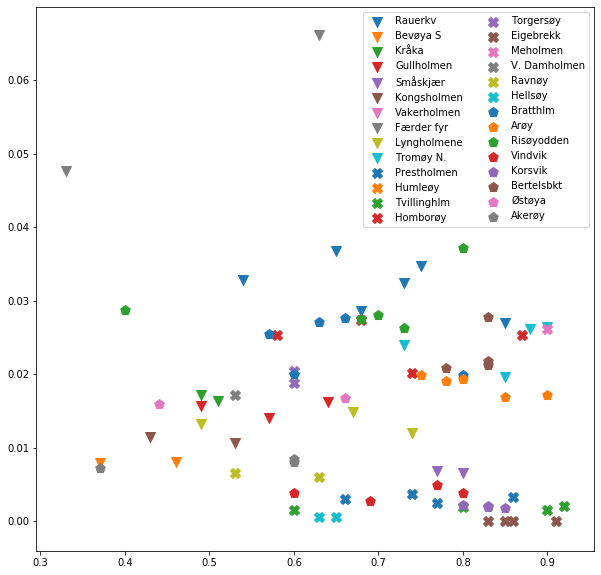

In [13]:
plt.figure(figsize=(10,10))
markers = ['v', 'X', 'p']
markercount = -1
for n in range(len(unique_stations)):  # loop over unique station ids
    station = unique_stations[n]
    if np.mod(n, 10) == 0:  # Remainder  of division. Will be zero for 0, 10, 20, 30, and so on
        markercount += 1 # Everytime this if statement is true, the marker symbol used for plotting will change
        mark = markers[markercount]
        
    is_station = dataframe['station_id']==station  # Find where in the dataframe station id is equal to the current station value
    new_dataframe = dataframe[is_station] # Extract that part into a new datafram
    plt.scatter(new_dataframe['msmdi'], new_dataframe['exposure'], s = 100, marker = mark, label = np.unique(new_dataframe['name'])[0])
plt.legend(ncol=2)

In [14]:
import pyromsobs 
obs = pyromsobs.OBSstruct('http://thredds.met.no/thredds/dodsC/metusers/arildb/Martini_Observations_Physical/martini_insitu_2017.nc')

temp = obs[np.where(obs.type == 6)]  # All observations of temperature has obs.type = 6
salt = obs[np.where(obs.type == 7)]  # All observations of temperature has obs.type = 7

No handles with labels found to put in legend.


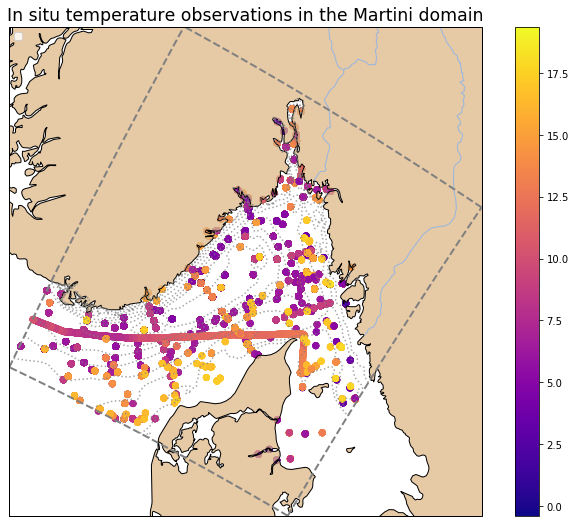

In [15]:
import roppy
filepath = 'http://thredds.met.no/thredds/dodsC/metusers/arildb/MARTINI800_prov_v2.ncml' # The OPENDAP URL
filehandle = Dataset(filepath) # open for reading 
grid = roppy.SGrid(filehandle) # Create a grid object for our file

mercator  = ccrs.Mercator() # Sets up the map projection 
fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw=dict(projection=mercator),  figsize=(12, 9))

ax.set_extent([np.min(grid.lon_rho),np.max(grid.lon_rho), np.min(grid.lat_rho), np.max(grid.lat_rho)], crs=ccrs.PlateCarree()) 
#ax.gridlines(linewidth = 1.5,color = 'gray', alpha = 0.4, linestyle = '--')

ax.plot(grid.lon_rho[0,:], grid.lat_rho[0,:], '--', transform= ccrs.PlateCarree(), color = 'gray', linewidth =2)
ax.plot(grid.lon_rho[-1,:], grid.lat_rho[-1,:], '--', transform= ccrs.PlateCarree(), color = 'gray', linewidth =2)  
ax.plot(grid.lon_rho[:,0], grid.lat_rho[:,0], '--', transform= ccrs.PlateCarree(), color = 'gray', linewidth =2)
ax.plot(grid.lon_rho[:,-1], grid.lat_rho[:,-1], '--', transform= ccrs.PlateCarree(), color = 'gray', linewidth =2)



ax.add_feature( land_10m, facecolor = 'burlywood', alpha = 0.75 )
ax.add_feature(coastline_10m) # Adding coastline
ax.add_feature(river_10m) # Drawing rivers.

im = ax.scatter(temp.lon, temp.lat, c = temp.value, transform = ccrs.PlateCarree(), cmap = plt.cm.plasma)
# Adding the depth contours, using the x,y coordinates specified for the native Martini-projection:
# Note that the transform argument points to the native martini projection we used above.
plt.colorbar(im)
ax.contour(grid.lon_rho, grid.lat_rho, grid.h, levels = [25, 50, 100, 200, 300, 400, 500], colors = 'gray', alpha = 0.7, linestyles = 'dotted', transform = ccrs.PlateCarree())



plt.legend(loc = 'upper left', ncol = 2);
plt.title('In situ temperature observations in the Martini domain', fontsize = 'xx-large');

No handles with labels found to put in legend.


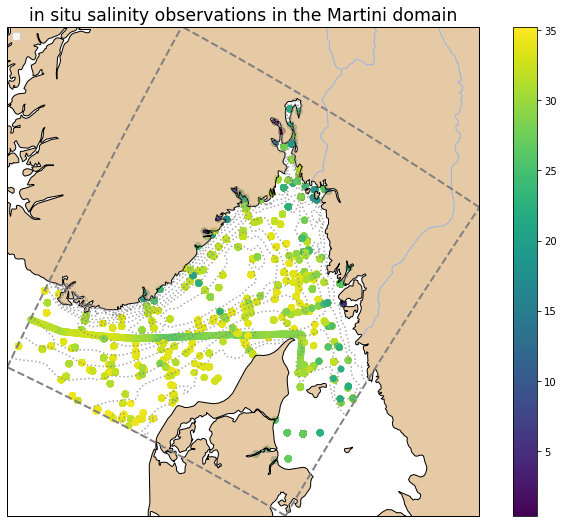

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw=dict(projection=mercator),  figsize=(12, 9))

ax.set_extent([np.min(grid.lon_rho),np.max(grid.lon_rho), np.min(grid.lat_rho), np.max(grid.lat_rho)], crs=ccrs.PlateCarree()) 
#ax.gridlines(linewidth = 1.5,color = 'gray', alpha = 0.4, linestyle = '--')

ax.plot(grid.lon_rho[0,:], grid.lat_rho[0,:], '--', transform= ccrs.PlateCarree(), color = 'gray', linewidth =2)
ax.plot(grid.lon_rho[-1,:], grid.lat_rho[-1,:], '--', transform= ccrs.PlateCarree(), color = 'gray', linewidth =2)  
ax.plot(grid.lon_rho[:,0], grid.lat_rho[:,0], '--', transform= ccrs.PlateCarree(), color = 'gray', linewidth =2)
ax.plot(grid.lon_rho[:,-1], grid.lat_rho[:,-1], '--', transform= ccrs.PlateCarree(), color = 'gray', linewidth =2)



ax.add_feature( land_10m, facecolor = 'burlywood', alpha = 0.75 )
ax.add_feature(coastline_10m) # Adding coastline
ax.add_feature(river_10m) # Drawing rivers.

im = ax.scatter(salt.lon, salt.lat, c = salt.value, transform = ccrs.PlateCarree(), cmap = plt.cm.viridis)
# Adding the depth contours, using the x,y coordinates specified for the native Martini-projection:
# Note that the transform argument points to the native martini projection we used above.
plt.colorbar(im)
ax.contour(grid.lon_rho, grid.lat_rho, grid.h, levels = [25, 50, 100, 200, 300, 400, 500], colors = 'gray', alpha = 0.7, linestyles = 'dotted', transform = ccrs.PlateCarree())



plt.legend(loc = 'upper left', ncol = 2);
plt.title('in situ salinity observations in the Martini domain', fontsize = 'xx-large');

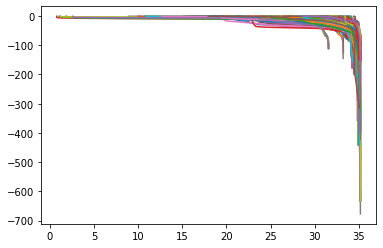

In [17]:
# Finding all temperature profiles on an observation object with more than 50 unique vertical measurements:
# (See attached plot for the result)
for name in obs.allvarnames(): 
    if not hasattr(obs, name): 
        setattr(obs,name, np.zeros_like(obs.lon)) 
OBS, Nprof, profileID = pyromsobs.get_profiles(obs, vartype=7, ndepths=100)

for n in range(Nprof): 
     plt.plot(OBS[np.where(profileID == n)].value, OBS[np.where(profileID == n)].depth) 

No handles with labels found to put in legend.


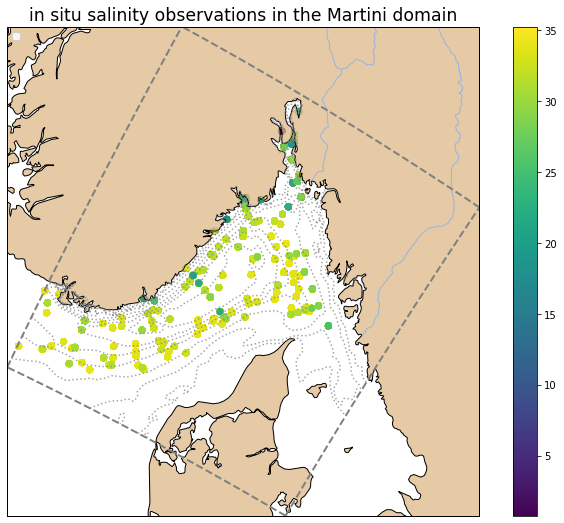

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw=dict(projection=mercator),  figsize=(12, 9))

ax.set_extent([np.min(grid.lon_rho),np.max(grid.lon_rho), np.min(grid.lat_rho), np.max(grid.lat_rho)], crs=ccrs.PlateCarree()) 
#ax.gridlines(linewidth = 1.5,color = 'gray', alpha = 0.4, linestyle = '--')

ax.plot(grid.lon_rho[0,:], grid.lat_rho[0,:], '--', transform= ccrs.PlateCarree(), color = 'gray', linewidth =2)
ax.plot(grid.lon_rho[-1,:], grid.lat_rho[-1,:], '--', transform= ccrs.PlateCarree(), color = 'gray', linewidth =2)  
ax.plot(grid.lon_rho[:,0], grid.lat_rho[:,0], '--', transform= ccrs.PlateCarree(), color = 'gray', linewidth =2)
ax.plot(grid.lon_rho[:,-1], grid.lat_rho[:,-1], '--', transform= ccrs.PlateCarree(), color = 'gray', linewidth =2)



ax.add_feature( land_10m, facecolor = 'burlywood', alpha = 0.75 )
ax.add_feature(coastline_10m) # Adding coastline
ax.add_feature(river_10m) # Drawing rivers.

im = ax.scatter(OBS.lon, OBS.lat, c = OBS.value, transform = ccrs.PlateCarree(), cmap = plt.cm.viridis)
# Adding the depth contours, using the x,y coordinates specified for the native Martini-projection:
# Note that the transform argument points to the native martini projection we used above.
plt.colorbar(im)
ax.contour(grid.lon_rho, grid.lat_rho, grid.h, levels = [25, 50, 100, 200, 300, 400, 500], colors = 'gray', alpha = 0.7, linestyles = 'dotted', transform = ccrs.PlateCarree())



plt.legend(loc = 'upper left', ncol = 2);
plt.title('in situ salinity observations in the Martini domain', fontsize = 'xx-large');

No handles with labels found to put in legend.


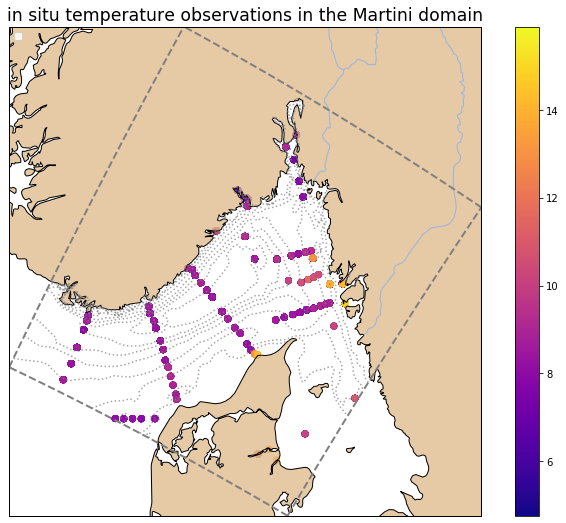

In [19]:
# observation time is given in number of days since 1 January 1970  
# Say we're only interested in observations during May
maystart = (datetime(2017,5,1) -datetime(1970,1,1)).total_seconds()/86400.  # 1 May 2017 00:00 as days since 1970
mayend = (datetime(2017,6,1) -datetime(1970,1,1)).total_seconds()/86400.  # 1 June 2017 00:00 as days since 1970

temp = temp[np.where( (temp.time >= maystart)  & (temp.time < mayend) ) ]
fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw=dict(projection=mercator),  figsize=(12, 9))

ax.set_extent([np.min(grid.lon_rho),np.max(grid.lon_rho), np.min(grid.lat_rho), np.max(grid.lat_rho)], crs=ccrs.PlateCarree()) 
#ax.gridlines(linewidth = 1.5,color = 'gray', alpha = 0.4, linestyle = '--')

ax.plot(grid.lon_rho[0,:], grid.lat_rho[0,:], '--', transform= ccrs.PlateCarree(), color = 'gray', linewidth =2)
ax.plot(grid.lon_rho[-1,:], grid.lat_rho[-1,:], '--', transform= ccrs.PlateCarree(), color = 'gray', linewidth =2)  
ax.plot(grid.lon_rho[:,0], grid.lat_rho[:,0], '--', transform= ccrs.PlateCarree(), color = 'gray', linewidth =2)
ax.plot(grid.lon_rho[:,-1], grid.lat_rho[:,-1], '--', transform= ccrs.PlateCarree(), color = 'gray', linewidth =2)



ax.add_feature( land_10m, facecolor = 'burlywood', alpha = 0.75 )
ax.add_feature(coastline_10m) # Adding coastline
ax.add_feature(river_10m) # Drawing rivers.

im = ax.scatter(temp.lon, temp.lat, c = temp.value, transform = ccrs.PlateCarree(), cmap = plt.cm.plasma)
# Adding the depth contours, using the x,y coordinates specified for the native Martini-projection:
# Note that the transform argument points to the native martini projection we used above.
plt.colorbar(im)
ax.contour(grid.lon_rho, grid.lat_rho, grid.h, levels = [25, 50, 100, 200, 300, 400, 500], colors = 'gray', alpha = 0.7, linestyles = 'dotted', transform = ccrs.PlateCarree())



plt.legend(loc = 'upper left', ncol = 2);
plt.title('in situ temperature observations in the Martini domain', fontsize = 'xx-large');